# Guía 6.2: Introducción a la minería de datos textuales en R

Computación 2, IES.
Profesor: Eduardo Jorquera, eduardo.jorquera@postgrado.uv.cl

# Ordenando los datos de Jane Austen

Las novelas de la escritora están en el paquete `janeaustenr` de R. El paquete mantiene el formato de una línea por fila, donde cada línea hace referencia a cada línea literal de un libro impreso. Usemos la función `mutate` para anotar los números de línea para poder guardar las líneas en el formato original  y `chapter` (usando regex) para hallar dónde están los capítulos.

In [2]:
library(janeaustenr)
library(dplyr)
library(stringr)

original_books <- austen_books() %>%
  group_by(book) %>%
  mutate(linenumber = row_number(),
         chapter = cumsum(str_detect(text, regex("^chapter [\\divxlc]",
                                                 ignore_case = TRUE)))) %>%
  ungroup()

original_books

text,book,linenumber,chapter
<chr>,<fct>,<int>,<int>
SENSE AND SENSIBILITY,Sense & Sensibility,1,0
,Sense & Sensibility,2,0
by Jane Austen,Sense & Sensibility,3,0
,Sense & Sensibility,4,0
(1811),Sense & Sensibility,5,0
,Sense & Sensibility,6,0
,Sense & Sensibility,7,0
,Sense & Sensibility,8,0
,Sense & Sensibility,9,0


Para trabajar con este dataset ordenado, necesitamos reestructurarlo en el formato *un token por fila*, lo cual se puede hacer con la función `unnest_tokens`:

In [4]:
library(tidytext)
tidy_books <- original_books %>%
  unnest_tokens(word, text)

head(tidy_books)

book,linenumber,chapter,word
<fct>,<int>,<int>,<chr>
Sense & Sensibility,1,0,sense
Sense & Sensibility,1,0,and
Sense & Sensibility,1,0,sensibility
Sense & Sensibility,3,0,by
Sense & Sensibility,3,0,jane
Sense & Sensibility,3,0,austen


Esta función usa el paquete `tokenizers` para separar cada línea de texto en el dataframe original a tokens. La tokenización por defecto es por palabra, pero se pueden incluir opciones que permita hacerlo por sentencia, párrafos, líneas, o separación respecto a un patrón de regex (expresiones regulares).

Ahora que los datos están en el formato *un término por fila*, podemos usar herramientas de manipulación con `dplyr`. Usualmente, en el análisis de texto querremos quitar las palabras vacías; éstas son, palabras que no aportan información. Podemos quitar estas palabras, con un `anti_join`:

In [6]:
data(stop_words)

tidy_books <- tidy_books %>%
  anti_join(stop_words)

Joining, by = "word"


Las palabras vacías en el paquete `tidytext` contienen palabras vacías de tres léxicos. Podemos usarlos todo junto, como lo tenemos aquí, o filtrar (`filter()`) para sólo usar un conjunto de palabras vacías si es más apropiado para ciertos análisis.

También podemos usar `count`, de `dplyr` para encontrar las palabras más comunes en todos los libros.

In [9]:
head(tidy_books %>%  count(word, sort = TRUE) )

word,n
<chr>,<int>
miss,1855
time,1337
fanny,862
dear,822
lady,817
sir,806


Ya que usamos herramientas de datos ordenados, nuestro conteo es almacenado como datos ordenados. Esto nos permite ir directamente a `ggplot2`, por ejemplo:

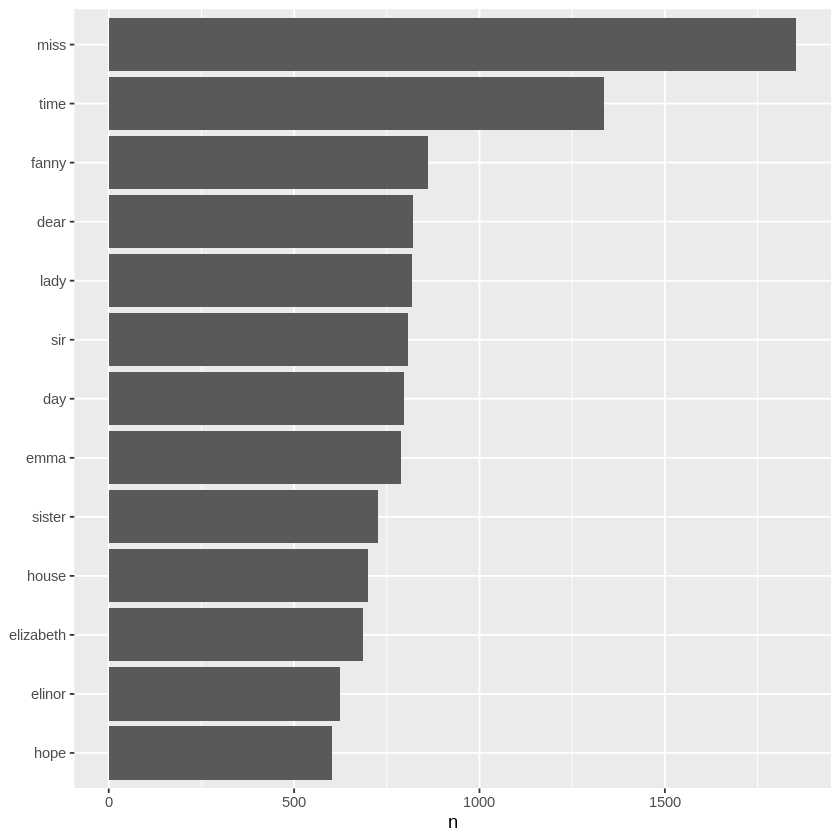

In [10]:
library(ggplot2)

tidy_books %>%
  count(word, sort = TRUE) %>%
  filter(n > 600) %>%
  mutate(word = reorder(word, n)) %>%
  ggplot(aes(word, n)) +
  geom_col() +
  xlab(NULL) +
  coord_flip()

Note que la función `austen_books()` entregó inmediatamente el texto que queremos analizar, pero para otros casos hay que limpiar el texto lo suficiente. Nota que hay más textos disponibles para análisis en paquetes como `gutenbergr`.

Para obtener la frecuencia de las palabras, podemos usar los principios de los datos ordenados. Usemos algunas colecciones de ciencia ficción y novelas fantasiosas de H.G. Wells: The Time Machine, The War of the Worlds, The Invisible Man, and The Island of Doctor Moreau. Podemos acceder a estos trabajos de la siguiente manera:

In [11]:
library(gutenbergr)

hgwells <- gutenberg_download(c(35, 36, 5230, 159))

Determining mirror for Project Gutenberg from http://www.gutenberg.org/robot/harvest
Using mirror http://aleph.gutenberg.org


In [12]:
tidy_hgwells <- hgwells %>%
  unnest_tokens(word, text) %>%
  anti_join(stop_words)

Joining, by = "word"


# Actividad:
¿Cuáles son las palabras más comunes en las novelas guardadas de H.G. Wells?

In [16]:
bronte <- gutenberg_download(c(1260, 768, 969, 9182, 767))
tidy_bronte <- bronte %>%
  unnest_tokens(word, text) %>%
  anti_join(stop_words)

Joining, by = "word"


Ahora calculemos la frecuencia para cada palabra de los trabajos de Jane Austen, hermanas Brontë y H.G. Wells, juntando dataframes. Podemos usar `spread` y `gather` de `tidyr` para cambiar la forma nuestro dataframe, y así sólo necesitamos hacer un gráfico para comparar estas tres novelas.

In [17]:
library(tidyr)

frequency <- bind_rows(mutate(tidy_bronte, author = "Brontë Sisters"),
                       mutate(tidy_hgwells, author = "H.G. Wells"), 
                       mutate(tidy_books, author = "Jane Austen")) %>% 
  mutate(word = str_extract(word, "[a-z']+")) %>%
  count(author, word) %>%
  group_by(author) %>%
  mutate(proportion = n / sum(n)) %>% 
  select(-n) %>% 
  spread(author, proportion) %>% 
  gather(author, proportion, `Brontë Sisters`:`H.G. Wells`)

Usamos `str_extract()` ya que los textos tienen codificación UTF-8, y hay algunas palabras con guión bajo que indican cierto énfasis (como cursivas).  El tokenizador cuenta separadamente las palabras, pero no queremos contar cualquier "_palabra_" de manera separada a "cualquier" otra palabra, como vimos anteriormente, por lo que usaremos `str_extract()`

Warning message:
“Removed 41357 rows containing missing values (geom_point).”Warning message:
“Removed 41359 rows containing missing values (geom_text).”

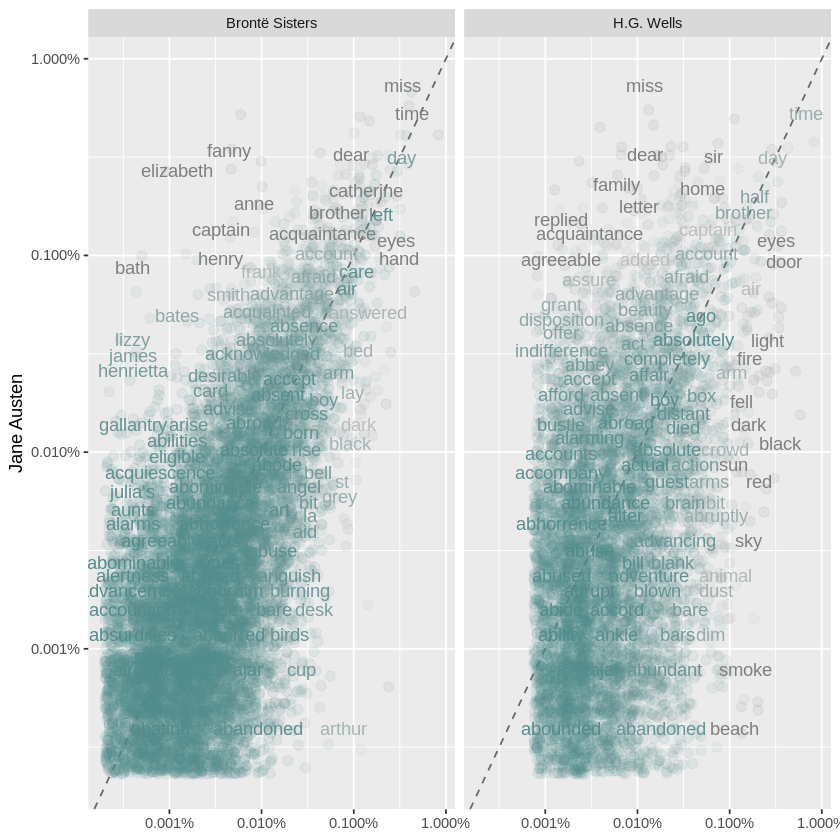

In [18]:
library(scales)

# expect a warning about rows with missing values being removed
ggplot(frequency, aes(x = proportion, y = `Jane Austen`, color = abs(`Jane Austen` - proportion))) +
  geom_abline(color = "gray40", lty = 2) +
  geom_jitter(alpha = 0.1, size = 2.5, width = 0.3, height = 0.3) +
  geom_text(aes(label = word), check_overlap = TRUE, vjust = 1.5) +
  scale_x_log10(labels = percent_format()) +
  scale_y_log10(labels = percent_format()) +
  scale_color_gradient(limits = c(0, 0.001), low = "darkslategray4", high = "gray75") +
  facet_wrap(~author, ncol = 2) +
  theme(legend.position="none") +
  labs(y = "Jane Austen", x = NULL)